##Model background
Here is an example based on the Henry saltwater intrusion problem.  The synthetic model is a 2-dimensional SEAWAT model (X-Z domain) with 1 row, 120 columns and 20 layers.  The left boundary is a specified flux of freshwater, the right boundary is a specified head and concentration saltwater boundary.  The model has two stress periods: an initial steady state (calibration) period, then a transient period with less flux (forecast).  

<img src="henry/domain.png" width=800/>

The inverse problem includes 601 parameters (600 hydraulic conductivity pilot points and 1 specified flux multiplier) and 36 obseravtions (21 heads and 15 concentrations) measured at the end of the steady state calibration period. Additional, zero-weight observations of head and concentration are also available at each observation location at the end of the transient forecast period as is the distance from the left edge of the domain to the 1%, 10% and 50% saltwater contours in the basal model layer at the end of the forecast stress period. These distances, named pd_one, pd_ten and pd_half are the forecasts we are interested in. I previously calculated the jacobian matrix, which is in the henry/ folder, along with the PEST control file.

Unlike the Schur's complement example notebook, here we will examine the consequences of not adjusting the specified flux multiplier parameter (```mult1```) during inversion.


##Using `pyemu`

In [1]:
%pylab inline
import os
import sys
import numpy as np
import pyemu
reload(pyemu)

Populating the interactive namespace from numpy and matplotlib


<module 'pyemu' from '/Users/jwhite/anaconda/lib/python2.7/site-packages/pyemu.pyc'>

First create a linear_analysis object.  We will use `err_var`  derived type, which replicates the behavior of the `PREDVAR` suite of PEST as well as `ident_par` utility.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.  Remember you can pass a filename to the `verbose` argument to write log file.

Since most groundwater model history-matching analyses focus on adjusting hetergeneous hydraulic properties and not boundary condition elements, let's identify the `mult1` parameter as `omitted` in the error variance analysis.  We can conceptually think of this action as excluding the `mult1` parameter from the history-matching process. Later we will explicitly calculate the penalty for not adjusting this parameter.

In [2]:
#forecasts = ["C_obs13_2","c_obs10_2","c_obs05_2"]
forecasts = ["pd_one","pd_ten","pd_half"]
la = pyemu.errvar(jco=os.path.join("henry", "pest.jco"), forecasts=forecasts, omitted_parameters="mult1")
print la.jco.shape #without the omitted parameter or the prior info

2015-03-30 14:37:16.696207 starting: pre-loading base components
2015-03-30 14:37:16.696323 starting: loading jco: henry/pest.jco
2015-03-30 14:37:16.701191 finished: loading jco: henry/pest.jco took: 0:00:00.004868
2015-03-30 14:37:16.701248 starting: loading pst: henry/pest.pst
2015-03-30 14:37:16.710825 finished: loading pst: henry/pest.pst took: 0:00:00.009577
2015-03-30 14:37:16.710875 starting: loading parcov
2015-03-30 14:37:16.791179 finished: loading parcov took: 0:00:00.080304
2015-03-30 14:37:16.791603 starting: loading obscov
2015-03-30 14:37:16.808363 finished: loading obscov took: 0:00:00.016760
2015-03-30 14:37:16.808414 starting: loading forecasts
2015-03-30 14:37:16.816294 finished: loading forecasts took: 0:00:00.007880
2015-03-30 14:37:16.816341 finished: pre-loading base components took: 0:00:00.120134
2015-03-30 14:37:16.816358 starting: dropping prior information
2015-03-30 14:37:16.816420 starting: removing 601 prior info from jco, pst, and obs cov
2015-03-30 14:

#Parameter identifiability
The `errvar` dervied type exposes a method to get a `pandas` dataframe of parameter identifiability information.  Recall that parameter identifiability is expressed as $d_i = \Sigma(\mathbf{V}_{1i})^2$, where $d_i$ is the parameter identifiability, which ranges from 0 (not identified by the data) to 1 (full identified by the data), and $\mathbf{V}_1$ are the right singular vectors corresonding to non-(numerically) zero singular values.  First let's look at the singular spectrum of $\mathbf{Q}^{\frac{1}{2}}\mathbf{J}$, where $\mathbf{Q}$ is the cofactor matrix and $\mathbf{J}$ is the jacobian:

In [3]:
s = la.qhalfx.s

2015-03-30 14:37:17.222237 starting: qhalf
2015-03-30 14:37:17.222618 finished: qhalf took: 0:00:00.000381


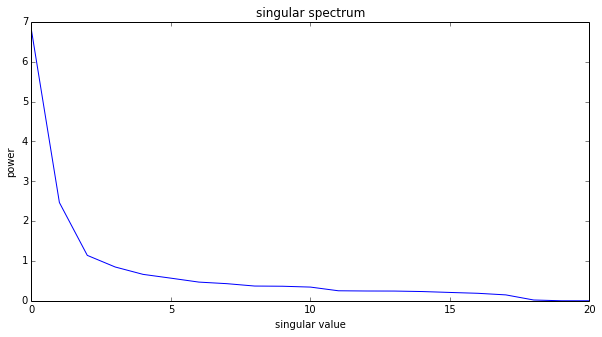

In [4]:
import pylab as plt
figure = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(s.x)
ax.set_title("singular spectrum")
ax.set_ylabel("power")
ax.set_xlabel("singular value")
ax.set_xlim(0,20)
plt.show()

We see that the singluar spectrum decays rapidly (not uncommon) and that we can really only support about 15 right singular vectors even though we have 600 parameters in the inverse problem.  

Let's get the identifiability dataframe at 15 singular vectors:

In [5]:
ident_df = la.get_identifiability_dataframe(15) # the method is passed the number of singular vectors to include in V_1

Plot the indentifiability:

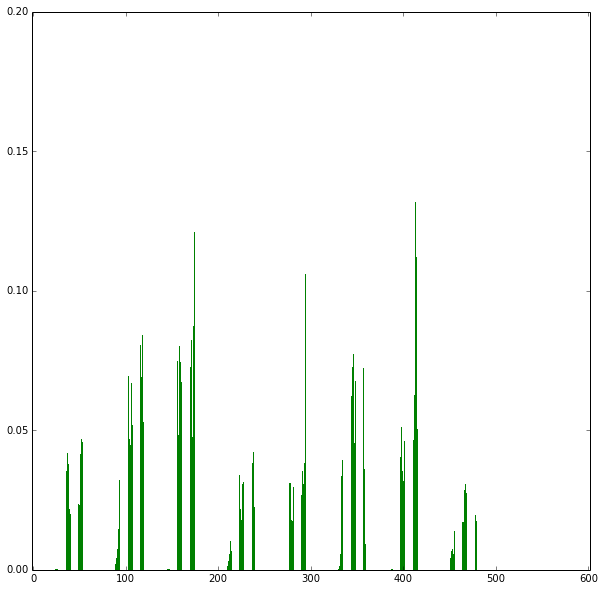

In [6]:
#print ident_df["right_sing_vec_1"].values
idx = np.arange(len(la.jco.col_names))
width = 0.4
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.bar(idx[:500],ident_df["ident"].values[:500],width=width,facecolor='g',edgecolor="none")
#for ising in xrange(5):
ax.set_xlim(-1,602)    
plt.show()
    

As expected in a highly parameterized inversion, we have "spread out" the identifiability to many individual hydraulic conductivity parameters so that no single parameter is dominate in the inverse problem.

#Forecast error variance 

Now let's explore the error variance of the forecasts we are interested in.  We will use an extended version of the forecast error variance equation:   

$\sigma_{s - \hat{s}}^2 = \underbrace{\textbf{y}_i^T({\bf{I}} - {\textbf{R}})\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_i}({\textbf{I}} - {\textbf{R}})^T\textbf{y}_i}_{1} + \underbrace{{\textbf{y}}_i^T{\bf{G}}\boldsymbol{\Sigma}_{\mathbf{\epsilon}}{\textbf{G}}^T{\textbf{y}}_i}_{2} + \underbrace{{\bf{p}}\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_o}{\bf{p}}^T}_{3}$

Where term 1 is the null-space contribution, term 2 is the solution space contribution and term 3 is the model error term (the penalty for not adjusting uncertain parameters).  Remember the `mult1` parameter that we marked as omitted?  The consequences of that action can now be explicitly evaluated.  See Moore and Doherty (2005) and White and other (2014) for more explanation of these terms.  Note that if you don't have any `omitted_parameters`, the only terms 1 and 2 contribute to error variance

First we need to create a list (or numpy ndarray) of the singular values we want to test.  Since we have $\lt40$ data, we only need to test up to $40$ singular values because that is where the action is:

In [7]:
sing_vals = np.arange(40)

The `errvar` derived type exposes a convience method to get a multi-index pandas dataframe with each of the terms of the error variance equation:

In [8]:
errvar_df = la.get_errvar_dataframe(sing_vals)
print errvar_df.index
print errvar_df.columns

2015-03-30 14:37:21.872077 starting: calc first term parameter @0
2015-03-30 14:37:21.907136 finished: calc first term parameter @0 took: 0:00:00.035059
2015-03-30 14:37:21.907218 starting: calc second term prediction @0
2015-03-30 14:37:21.912973 finished: calc second term prediction @0 took: 0:00:00.005755
2015-03-30 14:37:21.913051 starting: calc third term prediction @0
2015-03-30 14:37:21.914611 finished: calc third term prediction @0 took: 0:00:00.001560
2015-03-30 14:37:21.914663 starting: calc first term parameter @1
2015-03-30 14:37:21.944233 finished: calc first term parameter @1 took: 0:00:00.029570
2015-03-30 14:37:21.944700 starting: calc second term prediction @1
2015-03-30 14:37:21.945063 starting: calc G @1
2015-03-30 14:37:21.949196 finished: calc G @1 took: 0:00:00.004133
2015-03-30 14:37:21.953933 finished: calc second term prediction @1 took: 0:00:00.009233
2015-03-30 14:37:21.954020 starting: calc third term prediction @1
2015-03-30 14:37:21.955607 finished: calc t

plot the error variance components for each forecast:

pd_one 0.071737632503
pd_ten 0.128237705016
pd_half 0.113163367016


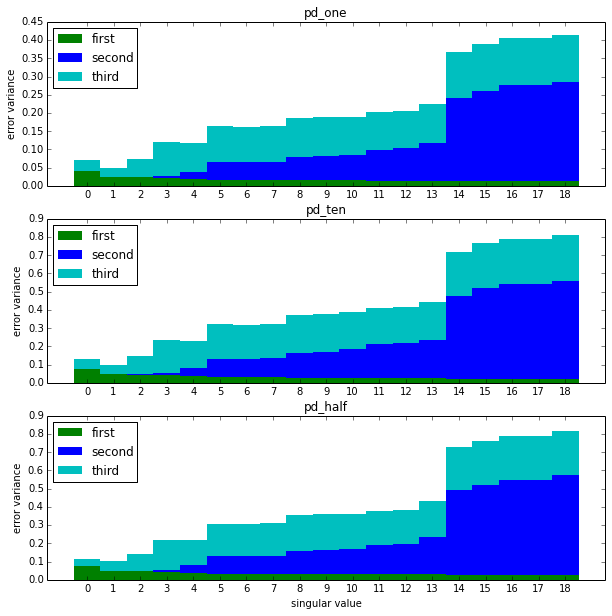

In [9]:
fig = plt.figure(figsize=(10, 10))
ax_1, ax_2, ax_3 = plt.subplot(311), plt.subplot(312), plt.subplot(313)
axes = [ax_1,ax_2,ax_3]

colors = {"first": 'g', "second": 'b', "third": 'c'}
max_idx = 19
idx = sing_vals[:max_idx]
for ipred, pred in enumerate(forecasts):
    pred = pred.lower()
    ax = axes[ipred]
    ax.set_title(pred)
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]
    third = errvar_df[("third", pred)][:max_idx]
    ax.bar(idx, first, width=1.0, edgecolor="none", facecolor=colors["first"], label="first",bottom=0.0)
    ax.bar(idx, second, width=1.0, edgecolor="none", facecolor=colors["second"], label="second", bottom=first)
    ax.bar(idx, third, width=1.0, edgecolor="none", facecolor=colors["third"], label="third", bottom=second+first)
    ax.set_xlim(-1,max_idx+1)
    ax.set_xticks(idx+0.5)
    ax.set_xticklabels(idx)
    if ipred == 2:
        ax.set_xlabel("singular value")
    
    ax.set_ylabel("error variance")
    ax.legend(loc="upper left")
    print pred,first[0] + second[0] + third[0]
    
plt.show()


Here we see the trade off between getting a good fit to push down the null-space (1st) term and the penalty for overfitting (the rise of the solution space (2nd) term)).  The sum of the first two terms in the "appearent" error variance (e.g. the uncertainty that standard analyses would yield) without considering the contribution from the omitted parameters.  You can verify this be checking prior uncertainty from the Schur's complement notebook against the zero singular value result using only terms 1 and 2.

We also see the added penalty for not adjusting the `mult1` parameter (3rd term).  The ability to forecast the distance from the left edge of the model to the three saltwater concentration contours has been compromised by not adjusting `mult1` during calibration.  

Notice how the shape of the trade off is different for each of the three forecasts, implying that we should calibrate the model differently for each prediction.  Note that the error variance at 0 singular values is the prior uncertainty of the forecast.

Let's check the ```errvar``` results against the results from ```schur```. This is simple with ```pyemu```, we simply  cast the ```errvar``` type to a ```schur``` type:

In [22]:
schur = la.get(astype=pyemu.schur)
schur_prior = schur.prior_forecast
schur_post = schur.posterior_forecast
print "{0:15s} {1:>15s} {2:>15s} {3:>15s} {4:>15s}".format("forecast","errvar prior","errvar min","schur prior", "schur post")
for ipred, pred in enumerate(forecasts):
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]  
    min_ev = np.min(first + second)
    prior_ev = first[0] + second[0]
    prior_sh = schur_prior[pred]
    post_sh = schur_post[pred]
    print "{0:15s} {1:15.6f} {2:15.6f} {3:15.6} {4:15.6f}".format(pred,prior_ev,min_ev,prior_sh,post_sh)

2015-03-30 14:46:57.174207 WARNING: linear_analysis.get(): astype is not None, but par_names and obs_names are None so
  ->Omitted attributes will not be propagated to new instance
forecast           errvar prior      errvar min     schur prior      schur post
pd_one                 0.040283        0.025041       0.0402826        0.023648
pd_ten                 0.075940        0.048628       0.0759402        0.045805
pd_half                0.073927        0.049253       0.0739274        0.046636


We see that the prior from ```schur``` class matches the two-term ```errvar``` result at zero singular values.  We also see, as expected, the posterior from ```schur``` is slightly lower than the two-term ```errvar``` result.

#Repeat analyses with different forecasts
Now let's look at some other forecasts: predicting the concentration at some observation locations at the end of the forecast period. This is easy with ```pyemu```.  We simple instanitate a new object with the desired forecasts.

In [31]:
forecasts = ["C_obs13_2","c_obs10_2","c_obs05_2"]
la = pyemu.errvar(jco=os.path.join("henry", "pest.jco"), forecasts=forecasts, omitted_parameters="mult1",verbose=False)


In [32]:
errvar_df = la.get_errvar_dataframe(sing_vals)

c_obs13_2 0.0557862588929
c_obs10_2 0.018090341033
c_obs05_2 0.00138795579438


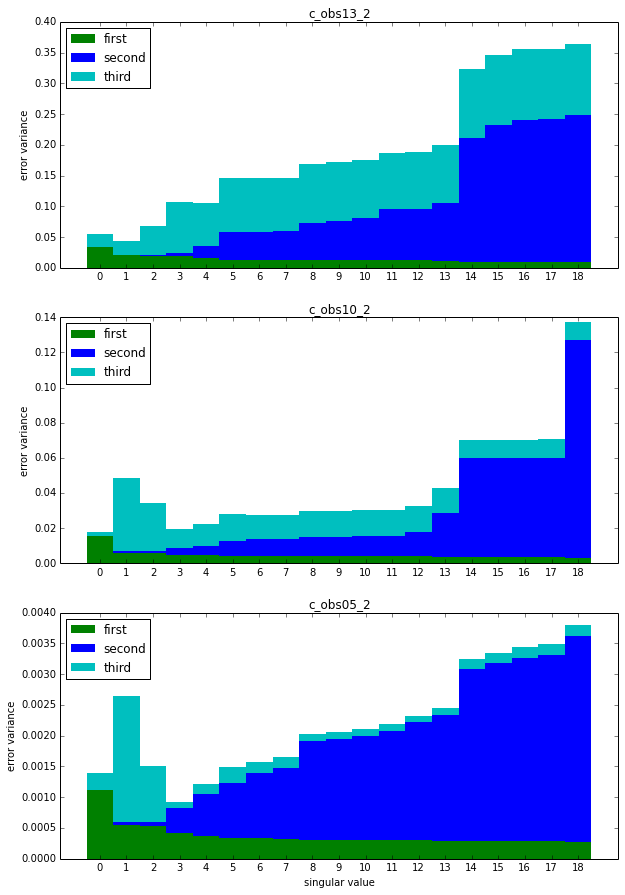

In [34]:
fig = plt.figure(figsize=(10, 15))
ax_1, ax_2, ax_3 = plt.subplot(311), plt.subplot(312), plt.subplot(313)
axes = [ax_1,ax_2,ax_3]

colors = {"first": 'g', "second": 'b', "third": 'c'}
max_idx = 19
idx = sing_vals[:max_idx]
for ipred, pred in enumerate(forecasts):
    pred = pred.lower()
    ax = axes[ipred]
    ax.set_title(pred)
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]
    third = errvar_df[("third", pred)][:max_idx]
    ax.bar(idx, first, width=1.0, edgecolor="none", facecolor=colors["first"], label="first",bottom=0.0)
    ax.bar(idx, second, width=1.0, edgecolor="none", facecolor=colors["second"], label="second", bottom=first)
    ax.bar(idx, third, width=1.0, edgecolor="none", facecolor=colors["third"], label="third", bottom=second+first)
    ax.set_xlim(-1,max_idx+1)
    ax.set_xticks(idx+0.5)
    ax.set_xticklabels(idx)
    if ipred == 2:
        ax.set_xlabel("singular value")
    
    ax.set_ylabel("error variance")
    ax.legend(loc="upper left")
    print pred,first[0] + second[0] + third[0]
    
plt.show()


The result is much different now.  Not adjusting the ```mult1``` parameter has seriouly compromised the reliable of forecast concentrations at location 10 and 5.  In fact, the uncertainty in these concentrations actually increases above the prior when 1 or 2 singular values are used, which implies we need to use more parameters so that parameter compensation can be localized.  